In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import datetime as dt

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',60)

In [2]:
def build_dataset(data_store = '../data'):
    csv_files_arr = []

    for directory in os.listdir(data_store):
        if directory.startswith(r'.'):
            continue
        sensor_placement = directory

        for subdirectory in os.listdir(os.path.join(data_store,directory)):
            if subdirectory.startswith(r'.'):
                continue
            if(os.path.isfile(os.path.join(data_store, directory, subdirectory))):
                continue

            activity = subdirectory

            for filename in os.listdir(os.path.join(data_store, directory, subdirectory)):
                if filename.endswith('.csv'):
                    user = filename.replace('.csv','')
                    csv_files_arr.append([os.path.abspath(os.path.join(data_store,directory,subdirectory,filename)),sensor_placement,
                                          activity,user])
                    
    person_data = {}
    
    for i,row in enumerate(csv_files_arr):
        path = row[0]
        sensor_placement = row[1]
        activity_class = row[2]
        user = row[3]
        
        if(sensor_placement!='w'):
            continue
        
        if user in person_data:
            activity_data = person_data[user]
        else:
            activity_data = {}
            
        if activity_class in activity_data:
            activity_df = activity_data[activity_class]
        else:
            activity_df = pd.DataFrame()
        
        _df = pd.read_csv(path)
        _df['m'] = np.sqrt(np.square(_df['x'].values)+np.square(_df['y'].values)+np.square(_df['z'].values))
        _df['user'] = user
        _df['activity_class'] = activity_class
        _df['epoch'] = _df['time'].apply(lambda x: ((dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f')-dt.datetime.utcfromtimestamp(0)).total_seconds())*1000)
        
        try:
            _df.drop(columns=['class'],inplace=True)
        except KeyError:
            pass
        
        activity_df = pd.concat([activity_df, _df])
        activity_data[activity_class] = activity_df
        person_data[user] = activity_data
    
    return person_data

person_data = build_dataset()
        
    

In [3]:
for person, activity_data in person_data.items():
    print(person)
    for activity_class, activity_df in activity_data.items():
        print(activity_class, activity_df.shape)
    print('\n\n')

034
downstairs (8366, 8)
upstairs (8703, 8)
walk_slow (17198, 8)
walk_fast (17154, 8)
standing (17228, 8)
sitting (17890, 8)
jogging (29820, 8)
lying (13967, 8)
walk_mod (17086, 8)



036
downstairs (8323, 8)
upstairs (8844, 8)
walk_slow (18673, 8)
walk_fast (17064, 8)
standing (17298, 8)
sitting (17921, 8)
jogging (29527, 8)
lying (19942, 8)
walk_mod (17083, 8)



033
downstairs (6417, 8)
upstairs (7389, 8)
walk_slow (17873, 8)
walk_fast (18213, 8)
standing (17888, 8)
sitting (17474, 8)
jogging (30763, 8)
lying (17543, 8)
walk_mod (17634, 8)



027
downstairs (7238, 8)
upstairs (8062, 8)
walk_slow (18006, 8)
walk_fast (17916, 8)
standing (18899, 8)
sitting (18477, 8)
jogging (29853, 8)
lying (17628, 8)
walk_mod (18281, 8)



026
downstairs (7556, 8)
upstairs (8491, 8)
walk_slow (18900, 8)
walk_fast (17516, 8)
standing (17450, 8)
sitting (18354, 8)
jogging (19926, 8)
lying (18364, 8)
walk_mod (17432, 8)



030
downstairs (5517, 8)
upstairs (6292, 8)
walk_slow (17553, 8)
walk_fast (1719

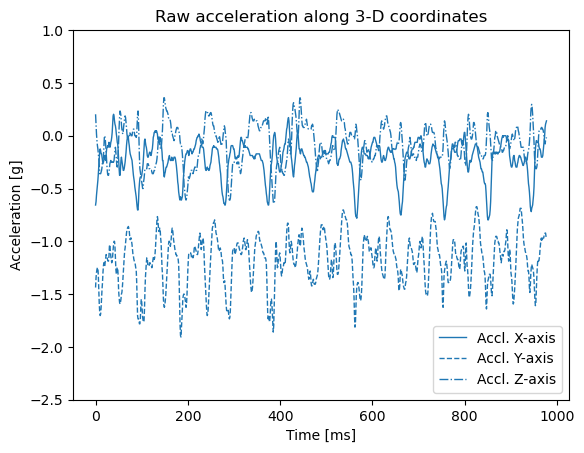

In [83]:
temp_df = time_windows[12][0]
x = temp_df['x']
y = temp_df['y']
z = temp_df['z']
m = temp_df['m']

fig,ax = plt.subplots()
ax.plot(np.linspace(0,x.size-1,x.size),temp_df['x'],color='tab:blue',lw=1,label='Accl. X-axis')
ax.plot(np.linspace(0,y.size-1,y.size),temp_df['y'],color='tab:blue',linestyle='--',lw=1,label='Accl. Y-axis')
ax.plot(np.linspace(0,z.size-1,z.size),temp_df['z'],color='tab:blue',linestyle='-.',lw=1,label='Accl. Z-axis')
# ax.plot(np.linspace(0,m.size-1,m.size),temp_df['m'],color='tab:green',lw=1.5,label='Accl. Magnitude')
ax.legend(loc='lower right')
ax.set_ylim(-2.5,1)

ax.set_title('Raw acceleration along 3-D coordinates')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Acceleration [g]')
plt.show()

In [4]:
from math import ceil

def build_time_windows(_df, time_len = 10, overlap_ratio = 0.5, min_time_len = 2,
                       sample_rate = 'auto', rate_calcref = 'epoch', sample_rate_multiplier = 1000):
    
    if(sample_rate=='auto'):
        sample_rate = (_df.shape[0]*sample_rate_multiplier)/(_df[rate_calcref].max()-_df[rate_calcref].min())
        
    elif(isinstance(sample_rate, (int,float))):
        raise TypeError("Parameter sample_rate expects int or float unless set to 'auto'; received {}".format(sample_rate))
    
    _twds = []
    
    idxwidth = ceil(sample_rate*time_len)
    min_idxwidth = ceil(sample_rate*min_time_len)
    increment = ceil(idxwidth*(1-overlap_ratio))
    
    n = _df.shape[0]
    i = 0
    
    while i<n:
        start = i
        end = start+idxwidth
        
        if ((end>n) or (n-end < min_idxwidth)):
            end = n-1
            i = n
        
        _dftw = _df.iloc[start:end].copy()
        _twds.append(_dftw)
        
        i+=increment
        
    return _twds

time_windows = []

for person, activity_data in person_data.items():
    for activity, activity_df in activity_data.items():
        time_windows.append(build_time_windows(activity_df))

len(time_windows)

_label_map = {'standing': 'sedentary', 'sitting':'sedentary', 'lying':'sedentary', 'jogging':'running', 
              'walk_slow':'walking', 'walk_mod':'walking', 'walk_fast':'walking', 'upstairs':'stairs', 
              'downstairs': 'stairs'}


In [5]:
# defining time domain features

def build_time_domain_features(time_windows):

    def td_sum(x):
        return np.sum(x)

    def td_mean(x):
        return np.mean(x)

    def td_std(x):
        return np.std(x)

    def td_percentile(x,p):
        return np.percentile(x,p)

    def td_iqr(x):
        return np.percentile(x,75)-np.percentile(x,25)

    def td_range(x):
        return np.max(x)-np.min(x)

    def td_power(x):
        return np.sum(np.square(x))

    def td_log_power(x, eps=10e-6):
        x = np.add(x,eps)
        return np.sum(np.log(np.square(x)))

    def td_energy(x, y, z):
        ex = np.sqrt(np.sum(np.square(np.subtract(x,np.mean(x)))))
        ey = np.sqrt(np.sum(np.square(np.subtract(y,np.mean(y)))))
        ez = np.sqrt(np.sum(np.square(np.subtract(z,np.mean(z)))))

        e = (1/(3 * len(x))) * (ex + ey + ez)
        return e
    
    def td_rms(x):
        return np.sqrt(np.mean(np.square(x)))


    time_domain_func = [td_sum, td_mean, td_std, td_iqr, td_range, td_power, td_log_power, td_rms, td_energy]
    time_domain_col = ['epoch_start','epoch_end','user','activity_class','class']

    for func in time_domain_func:
        if(func in [td_energy]):
            time_domain_col.append(func.__name__)
            continue
        for axis in ['x','y','z','m']:
            time_domain_col.append(func.__name__+'_'+axis)

    time_domain_features = []

    for useract_winset in time_windows:
        for twdf in useract_winset:
            twdf_features = []
            twdf_features.extend([twdf['epoch'].min(), twdf['epoch'].max(), 
                                 twdf['user'].unique()[0], twdf['activity_class'].unique()[0],
                                 _label_map[twdf['activity_class'].unique()[0]]])

            for func in time_domain_func:
                if(func in [td_energy]):
                    twdf_features.extend([func(twdf['x'].values, twdf['y'].values, twdf['z'].values)])
                    continue
                twdf_features.extend([func(twdf['x'].values), func(twdf['y'].values), 
                                      func(twdf['z'].values), func(twdf['m'].values)])

            time_domain_features.append(twdf_features)

    time_domain_df = pd.DataFrame(time_domain_features, columns=time_domain_col)
    return time_domain_df
    
time_domain_df = build_time_domain_features(time_windows)
time_domain_df

,epoch_start,epoch_end,user,activity_class,class,td_sum_x,td_sum_y,td_sum_z,td_sum_m,td_mean_x,td_mean_y,td_mean_z,td_mean_m,td_std_x,td_std_y,td_std_z,td_std_m,td_iqr_x,td_iqr_y,td_iqr_z,td_iqr_m,td_range_x,td_range_y,td_range_z,td_range_m,td_power_x,td_power_y,td_power_z,td_power_m,td_log_power_x,td_log_power_y,td_log_power_z,td_log_power_m,td_rms_x,td_rms_y,td_rms_z,td_rms_m,td_energy
0,1.461149e+12,1.461149e+12,034,downstairs,stairs,-338.875000,-940.234375,-107.218750,1038.139884,-0.347564,-0.964343,-0.109968,1.064759,0.260323,0.377101,0.183482,0.415666,0.226562,0.460938,0.187500,0.498218,2.390625,1.937500,1.640625,2.099636,183.854492,1045.358154,44.614746,1273.827393,-2400.145856,-204.390575,-5805.100453,-10.259216,0.434245,1.035453,0.213913,1.143018,0.008763
1,1.461149e+12,1.461149e+12,034,downstairs,stairs,-316.109375,-946.656250,-108.203125,1040.468241,-0.324215,-0.970929,-0.110978,1.067147,0.261514,0.368025,0.180813,0.397314,0.250000,0.484375,0.203125,0.508525,2.781250,1.953125,1.453125,2.016667,169.167236,1051.192871,43.884033,1264.244141,-2570.470164,-186.076819,-5653.900424,3.568909,0.416539,1.038338,0.212154,1.138710,0.008651
2,1.461149e+12,1.461149e+12,034,downstairs,stairs,-311.218750,-946.265625,-117.875000,1034.081133,-0.319199,-0.970529,-0.120897,1.060596,0.215161,0.322750,0.181061,0.341776,0.203125,0.343750,0.203125,0.423340,2.390625,1.765625,1.437500,1.649355,144.477539,1019.941162,46.214355,1210.633057,-2598.059826,-154.847474,-4989.097434,24.533427,0.384944,1.022787,0.217714,1.114305,0.007675
3,1.461149e+12,1.461149e+12,034,downstairs,stairs,-290.687500,-948.281250,-140.656250,1032.910278,-0.298141,-0.972596,-0.144263,1.059395,0.211231,0.303750,0.168489,0.314001,0.187500,0.296875,0.210938,0.288431,1.937500,1.703125,1.125000,1.718577,130.168945,1012.252441,47.970215,1190.391602,-2539.890283,-140.682956,-4527.122899,35.874748,0.365386,1.018925,0.221811,1.104950,0.007296
4,1.461149e+12,1.461149e+12,034,downstairs,stairs,-323.875000,-933.843750,-103.156250,1028.847612,-0.332179,-0.957788,-0.105801,1.055228,0.239908,0.319935,0.167989,0.336932,0.250000,0.367188,0.203125,0.353418,1.937500,1.609375,1.218750,1.718577,163.701660,994.224121,38.428711,1196.354492,-2399.338411,-184.820264,-5024.393563,13.861764,0.409755,1.009810,0.198530,1.107714,0.007770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9376,1.461765e+12,1.461765e+12,039,walk_mod,walking,-289.671875,-1079.046875,259.593750,1197.087421,-0.296491,-1.104449,0.265705,1.225269,0.283011,0.176167,0.233281,0.206351,0.265625,0.203125,0.328125,0.270163,2.187500,1.265625,1.296875,1.300414,164.137939,1222.073486,122.143555,1508.354980,-2630.294177,169.538976,-3494.025961,369.522291,0.409880,1.118411,0.353580,1.242523,0.007385
9377,1.461765e+12,1.461765e+12,039,walk_mod,walking,-283.062500,-1088.968750,220.718750,1198.461892,-0.289726,-1.114605,0.225915,1.226675,0.295041,0.197856,0.220886,0.218120,0.265625,0.218750,0.312500,0.293856,2.484375,1.312500,1.437500,1.390373,167.057617,1252.016113,97.532227,1516.605957,-2675.218646,181.210782,-3836.528203,368.732755,0.413510,1.132029,0.315956,1.245917,0.007612
9378,1.461765e+12,1.461765e+12,039,walk_mod,walking,-361.531250,-1023.578125,215.984375,1172.406654,-0.370042,-1.047675,0.221069,1.200007,0.298819,0.248400,0.244612,0.232893,0.281250,0.296875,0.328125,0.300131,2.500000,1.484375,1.687500,1.311176,221.020996,1132.660400,106.206299,1459.887695,-2290.130953,28.497101,-3591.193035,318.382866,0.475630,1.076719,0.329707,1.222397,0.008444
9379,1.461765e+12,1.461765e+12,039,walk_mod,walking,-431.859375,-914.015625,232.562500,1090.999539,-0.442026,-0.935533,0.238037,1.116683,0.255339,0.232909,0.227098,0.226511,0.296875,0.328125,0.281250,0.314405,1.750000,1.531250,1.546875,1.665688,254.591553,908.090576,105.746094,1268.428223,-1910.737916,-211.920665,-3321.712152,174.479153,0.510475,0.964089,0.328992,1.139425,0.007629


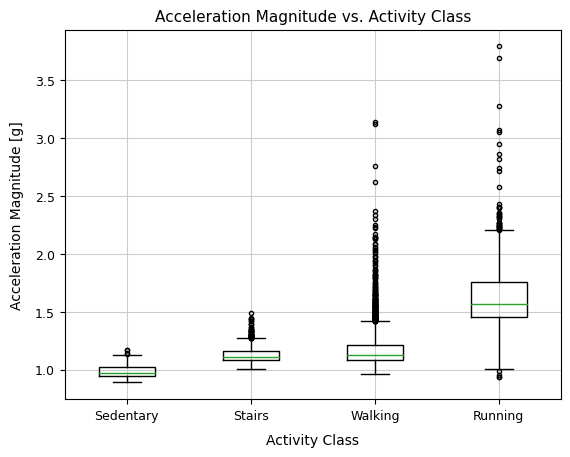

In [41]:
td_power_group_df = time_domain_df.groupby(['class']).agg({'td_mean_m': lambda x: list(x)})
td_power_group_df = td_power_group_df.reset_index().set_index('class')
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
td_power_group_df = td_power_group_df.sort_values(by=['class'],key= lambda x: x.map(class_custom_order))
td_power_group_dict = td_power_group_df.to_dict()['td_mean_m']
td_power_group_dict

fig,ax = plt.subplots()
bp = ax.boxplot(td_power_group_dict.values(),sym='.',medianprops=dict(color='tab:green'))
plt.title('Acceleration Magnitude vs. Activity Class',fontsize=11)
ax.tick_params(axis='both', which='major',labelsize=9)

# format ticks, tick labels, axis labels
ax.set_ylabel('Acceleration Magnitude [g]',fontsize=10,labelpad=8)
ax.set_xticklabels(['Sedentary','Stairs','Walking','Running'],fontdict=dict(fontsize=9))
ax.set_xlabel('Activity Class',fontsize=10,labelpad=8)

plt.grid(visible=True, which='major', color='0.8', linestyle='-')
plt.show()


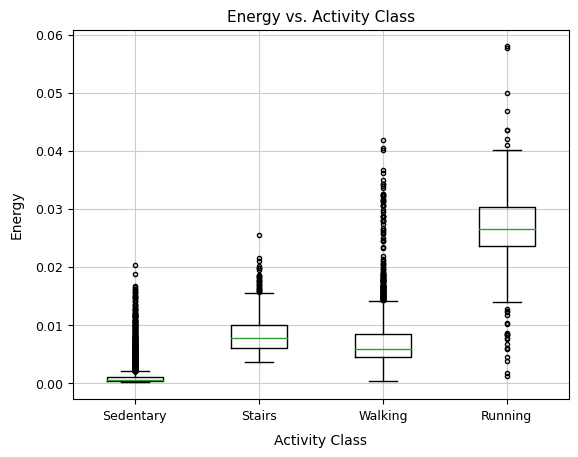

In [7]:
td_power_group_df = time_domain_df.groupby(['class']).agg({'td_energy': lambda x: list(x)})
td_power_group_df = td_power_group_df.reset_index().set_index('class')
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
td_power_group_df = td_power_group_df.sort_values(by=['class'],key= lambda x: x.map(class_custom_order))
td_power_group_dict = td_power_group_df.to_dict()['td_energy']
td_power_group_dict

fig,ax = plt.subplots()
bp = ax.boxplot(td_power_group_dict.values(),sym='.',medianprops=dict(color='tab:green'))
plt.title('Energy vs. Activity Class',fontsize=11)
ax.tick_params(axis='both', which='major',labelsize=9)

# format ticks, tick labels, axis labels
ax.set_ylabel('Energy',fontsize=10,labelpad=8)
ax.set_xticklabels(['Sedentary','Stairs','Walking','Running'],fontdict=dict(fontsize=9))
ax.set_xlabel('Activity Class',fontsize=10,labelpad=8)

plt.grid(visible=True, which='major', color='0.8', linestyle='-')
plt.show()


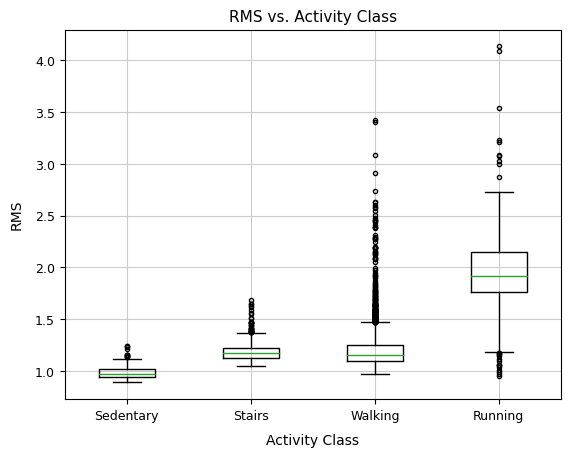

In [36]:
td_power_group_df = time_domain_df.groupby(['class']).agg({'td_rms_m': lambda x: list(x)})
td_power_group_df = td_power_group_df.reset_index().set_index('class')
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
td_power_group_df = td_power_group_df.sort_values(by=['class'],key= lambda x: x.map(class_custom_order))
td_power_group_dict = td_power_group_df.to_dict()['td_rms_m']
td_power_group_dict

fig,ax = plt.subplots()
bp = ax.boxplot(td_power_group_dict.values(),sym='.',medianprops=dict(color='tab:green'))
plt.title('RMS vs. Activity Class',fontsize=11)
ax.tick_params(axis='both', which='major',labelsize=9)

# format ticks, tick labels, axis labels
ax.set_ylabel('RMS',fontsize=10,labelpad=8)
ax.set_xticklabels(['Sedentary','Stairs','Walking','Running'],fontdict=dict(fontsize=9))
ax.set_xlabel('Activity Class',fontsize=10,labelpad=8)

plt.grid(visible=True, which='major', color='0.8', linestyle='-')
plt.show()


In [9]:
from detecta import detect_peaks
from scipy.signal import butter, lfilter

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'p%s' % n
    return percentile_

def build_freq_domain_features(time_windows):

    def fd_dominant_freq(x, t):
        """Returns the dominant frequency of x in Hz."""
        n = x.size
        dt = t/n
        df = 1/t
        
        X = np.fft.fft(x)
        freqs = np.fft.fftfreq(n)*n*df
        
        if n%2==0:
            eff_size = int(n/2)
        else:
            eff_size = int((n+1)/2)
        
        idx = np.argmax(np.abs(X[1:eff_size]))
        freq = freqs[1:eff_size][idx]
        return freq
    
    def fd_spectral_entropy(x):
        """Returns the spectral entropy of a signal"""
        n = x.size
        p = np.square(x)/n
        pi = p/np.sum(p) + 1e-15
        H = -np.sum(pi*np.log2(pi))/(np.log2(n))
        return H
    
    def fd_step_counter(m):
        """Estimates number of steps based on number of peaks in the mag vector"""
        
        def _filter_signal(x, samp_rate=100, high=2, order=5):
            nyq = 0.5 * samp_rate    
            high = high/nyq
            b, a = butter(order, high)
            y = lfilter(b, a, x)
            return y
        
        y = _filter_signal(m, samp_rate=100, high=2)
        peaks = detect_peaks(y, mph=1.2)
        steps = len(peaks)
        return steps
    
    
    freq_domain_func = [fd_dominant_freq, fd_step_counter, fd_spectral_entropy]
    freq_domain_col = ['epoch_start','epoch_end','user','activity_class','class']

    for func in freq_domain_func:
        for axis in ['x','y','z','m']:
            freq_domain_col.append(func.__name__+'_'+axis)

    freq_domain_features = []

    for useract_winset in time_windows:
        for twdf in useract_winset:
            twdf_features = []
            twdf_features.extend([twdf['epoch'].min(), twdf['epoch'].max(), 
                                  twdf['user'].unique()[0], twdf['activity_class'].unique()[0],
                                 _label_map[twdf['activity_class'].unique()[0]]])
            
            signal_secs = (twdf['epoch'].max()-twdf['epoch'].min())/1000

            for func in freq_domain_func:
                if func in [fd_dominant_freq]:
                    twdf_features.extend([func(twdf['x'].values, signal_secs), func(twdf['y'].values, signal_secs), 
                                          func(twdf['z'].values, signal_secs), func(twdf['m'].values, signal_secs)])
                else:
                    twdf_features.extend([func(twdf['x'].values), func(twdf['y'].values),
                                          func(twdf['z'].values), func(twdf['m'].values)])

            freq_domain_features.append(twdf_features)

    freq_domain_df = pd.DataFrame(freq_domain_features, columns=freq_domain_col)
    return freq_domain_df
    
freq_domain_df = build_freq_domain_features(time_windows)
freq_domain_df


/var/folders/hz/mq1t9krj4kv9cxjz4g5c_p8c0000gn/T/ipykernel_30937/3031056921.py:34: RuntimeWarning: invalid value encountered in true_divide
  pi = p/np.sum(p) + 1e-15


,epoch_start,epoch_end,user,activity_class,class,fd_dominant_freq_x,fd_dominant_freq_y,fd_dominant_freq_z,fd_dominant_freq_m,fd_step_counter_x,fd_step_counter_y,fd_step_counter_z,fd_step_counter_m,fd_spectral_entropy_x,fd_spectral_entropy_y,fd_spectral_entropy_z,fd_spectral_entropy_m
0,1.461149e+12,1.461149e+12,034,downstairs,stairs,2.000600,1.700510,1.500450,1.700510,0,0,0,13,0.908280,0.958818,0.836516,0.958852
1,1.461149e+12,1.461149e+12,034,downstairs,stairs,3.501751,1.700850,1.700850,1.700850,0,0,0,13,0.916588,0.961436,0.859245,0.962591
2,1.461149e+12,1.461149e+12,034,downstairs,stairs,3.402382,1.701191,1.701191,1.701191,0,0,0,13,0.931042,0.969089,0.875511,0.970831
3,1.461149e+12,1.461149e+12,034,downstairs,stairs,2.299540,1.599680,1.599680,1.599680,0,0,0,12,0.944229,0.972427,0.906565,0.974805
4,1.461149e+12,1.461149e+12,034,downstairs,stairs,3.102172,1.501051,1.601121,1.501051,0,0,0,13,0.937462,0.969243,0.883607,0.971535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9376,1.461765e+12,1.461765e+12,039,walk_mod,walking,1.001603,1.001603,1.001603,1.001603,0,0,0,14,0.923104,0.992680,0.897571,0.991896
9377,1.461765e+12,1.461765e+12,039,walk_mod,walking,1.101652,2.303455,1.101652,2.103155,0,0,0,14,0.915709,0.991012,0.880345,0.990959
9378,1.461765e+12,1.461765e+12,039,walk_mod,walking,1.001101,0.100110,1.001101,0.100110,0,0,0,12,0.923322,0.985195,0.886997,0.989508
9379,1.461765e+12,1.461765e+12,039,walk_mod,walking,1.000600,2.101261,1.000600,2.101261,0,0,0,11,0.937281,0.984211,0.906135,0.988520


In [86]:
freq_domain_df.groupby(['class']).agg({'fd_dominant_freq_x':[np.min, percentile(25), percentile(50),
                                                             percentile(75), np.max]})


fd_dominant_freq_x                                         
                        amin       p25       p50       p75       amax
class                                                                
running             0.099940  2.502252  2.601301  2.701621   9.603842
sedentary           0.083410  0.100040  0.104037  0.600195  47.823912
stairs              0.085099  0.800721  1.000600  1.599680   4.202522
walking             0.084595  0.800560  0.901442  1.099890   6.107940

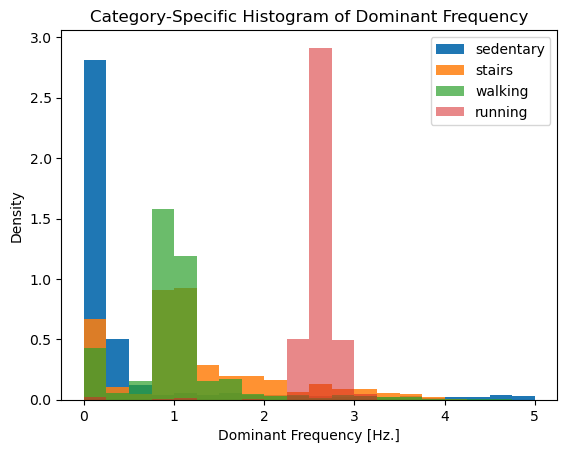

In [143]:
cat_hist_df = freq_domain_df.sort_values(['class'],key= lambda x: x.map(class_custom_order))
classes = cat_hist_df['class'].unique()

for i,c in enumerate(classes):
    plt.hist(cat_hist_df[cat_hist_df['class']==c]['fd_dominant_freq_x'], alpha=1-i*0.15, label=c,
             density=True, bins=20, range=(0,5))
plt.title('Category-Specific Histogram of Dominant Frequency')
plt.xlabel('Dominant Frequency [Hz.]')
plt.ylabel('Density')
plt.legend()
plt.show()

In [10]:
time_freq_domain_df = pd.merge(left=time_domain_df, right=freq_domain_df, left_index=True, right_index=True,
                               how='outer', suffixes=('','_drop'))
time_freq_domain_df.drop(columns=[col_name for col_name in time_freq_domain_df.columns if '_drop' in col_name],inplace=True)
time_freq_domain_df


,epoch_start,epoch_end,user,activity_class,class,td_sum_x,td_sum_y,td_sum_z,td_sum_m,td_mean_x,td_mean_y,td_mean_z,td_mean_m,td_std_x,td_std_y,td_std_z,td_std_m,td_iqr_x,td_iqr_y,td_iqr_z,td_iqr_m,td_range_x,td_range_y,td_range_z,td_range_m,td_power_x,td_power_y,td_power_z,td_power_m,td_log_power_x,td_log_power_y,td_log_power_z,td_log_power_m,td_rms_x,td_rms_y,td_rms_z,td_rms_m,td_energy,fd_dominant_freq_x,fd_dominant_freq_y,fd_dominant_freq_z,fd_dominant_freq_m,fd_step_counter_x,fd_step_counter_y,fd_step_counter_z,fd_step_counter_m,fd_spectral_entropy_x,fd_spectral_entropy_y,fd_spectral_entropy_z,fd_spectral_entropy_m
0,1.461149e+12,1.461149e+12,034,downstairs,stairs,-338.875000,-940.234375,-107.218750,1038.139884,-0.347564,-0.964343,-0.109968,1.064759,0.260323,0.377101,0.183482,0.415666,0.226562,0.460938,0.187500,0.498218,2.390625,1.937500,1.640625,2.099636,183.854492,1045.358154,44.614746,1273.827393,-2400.145856,-204.390575,-5805.100453,-10.259216,0.434245,1.035453,0.213913,1.143018,0.008763,2.000600,1.700510,1.500450,1.700510,0,0,0,13,0.908280,0.958818,0.836516,0.958852
1,1.461149e+12,1.461149e+12,034,downstairs,stairs,-316.109375,-946.656250,-108.203125,1040.468241,-0.324215,-0.970929,-0.110978,1.067147,0.261514,0.368025,0.180813,0.397314,0.250000,0.484375,0.203125,0.508525,2.781250,1.953125,1.453125,2.016667,169.167236,1051.192871,43.884033,1264.244141,-2570.470164,-186.076819,-5653.900424,3.568909,0.416539,1.038338,0.212154,1.138710,0.008651,3.501751,1.700850,1.700850,1.700850,0,0,0,13,0.916588,0.961436,0.859245,0.962591
2,1.461149e+12,1.461149e+12,034,downstairs,stairs,-311.218750,-946.265625,-117.875000,1034.081133,-0.319199,-0.970529,-0.120897,1.060596,0.215161,0.322750,0.181061,0.341776,0.203125,0.343750,0.203125,0.423340,2.390625,1.765625,1.437500,1.649355,144.477539,1019.941162,46.214355,1210.633057,-2598.059826,-154.847474,-4989.097434,24.533427,0.384944,1.022787,0.217714,1.114305,0.007675,3.402382,1.701191,1.701191,1.701191,0,0,0,13,0.931042,0.969089,0.875511,0.970831
3,1.461149e+12,1.461149e+12,034,downstairs,stairs,-290.687500,-948.281250,-140.656250,1032.910278,-0.298141,-0.972596,-0.144263,1.059395,0.211231,0.303750,0.168489,0.314001,0.187500,0.296875,0.210938,0.288431,1.937500,1.703125,1.125000,1.718577,130.168945,1012.252441,47.970215,1190.391602,-2539.890283,-140.682956,-4527.122899,35.874748,0.365386,1.018925,0.221811,1.104950,0.007296,2.299540,1.599680,1.599680,1.599680,0,0,0,12,0.944229,0.972427,0.906565,0.974805
4,1.461149e+12,1.461149e+12,034,downstairs,stairs,-323.875000,-933.843750,-103.156250,1028.847612,-0.332179,-0.957788,-0.105801,1.055228,0.239908,0.319935,0.167989,0.336932,0.250000,0.367188,0.203125,0.353418,1.937500,1.609375,1.218750,1.718577,163.701660,994.224121,38.428711,1196.354492,-2399.338411,-184.820264,-5024.393563,13.861764,0.409755,1.009810,0.198530,1.107714,0.007770,3.102172,1.501051,1.601121,1.501051,0,0,0,13,0.937462,0.969243,0.883607,0.971535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9376,1.461765e+12,1.461765e+12,039,walk_mod,walking,-289.671875,-1079.046875,259.593750,1197.087421,-0.296491,-1.104449,0.265705,1.225269,0.283011,0.176167,0.233281,0.206351,0.265625,0.203125,0.328125,0.270163,2.187500,1.265625,1.296875,1.300414,164.137939,1222.073486,122.143555,1508.354980,-2630.294177,169.538976,-3494.025961,369.522291,0.409880,1.118411,0.353580,1.242523,0.007385,1.001603,1.001603,1.001603,1.001603,0,0,0,14,0.923104,0.992680,0.897571,0.991896
9377,1.461765e+12,1.461765e+12,039,walk_mod,walking,-283.062500,-1088.968750,220.718750,1198.461892,-0.289726,-1.114605,0.225915,1.226675,0.295041,0.197856,0.220886,0.218120,0.265625,0.218750,0.312500,0.293856,2.484375,1.312500,1.437500,1.390373,167.057617,1252.016113,97.532227,1516.605957,-2675.218646,181.210782,-3836.528203,368.732755,0.413510,1.132029,0.315956,1.245917,0.007612,

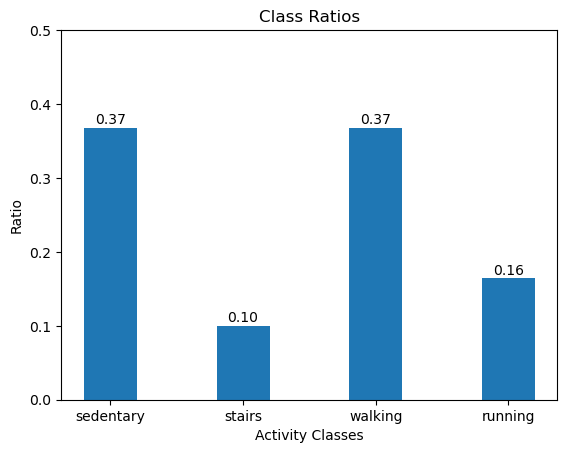

In [115]:
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
class_balance = time_freq_domain_df['class'].value_counts()/time_freq_domain_df['class'].value_counts().sum()
class_balance.sort_index(key=lambda x: x.map(class_custom_order),inplace=True)

fig,ax = plt.subplots()
ax.bar(x=class_balance.index, height=class_balance.values, width=0.4)
ax.set_title('Class Ratios')
ax.set_xlabel('Activity Classes')
ax.set_ylabel('Ratio')
ax.set_ylim(0,0.5)

rects = ax.patches

# Make some labels.
labels = ['{:.02f}'.format(i) for i in class_balance.values]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.001, label, ha="center", va="bottom")

plt.show()

In [98]:
class_balance.values

array([0.36797783, 0.10030914, 0.36765803, 0.164055  ])

In [95]:
class_balance.sort_index(key=lambda x: x.map(class_custom_order))

sedentary    0.367978
stairs       0.100309
walking      0.367658
running      0.164055
Name: class, dtype: float64

In [11]:
import seaborn as sns


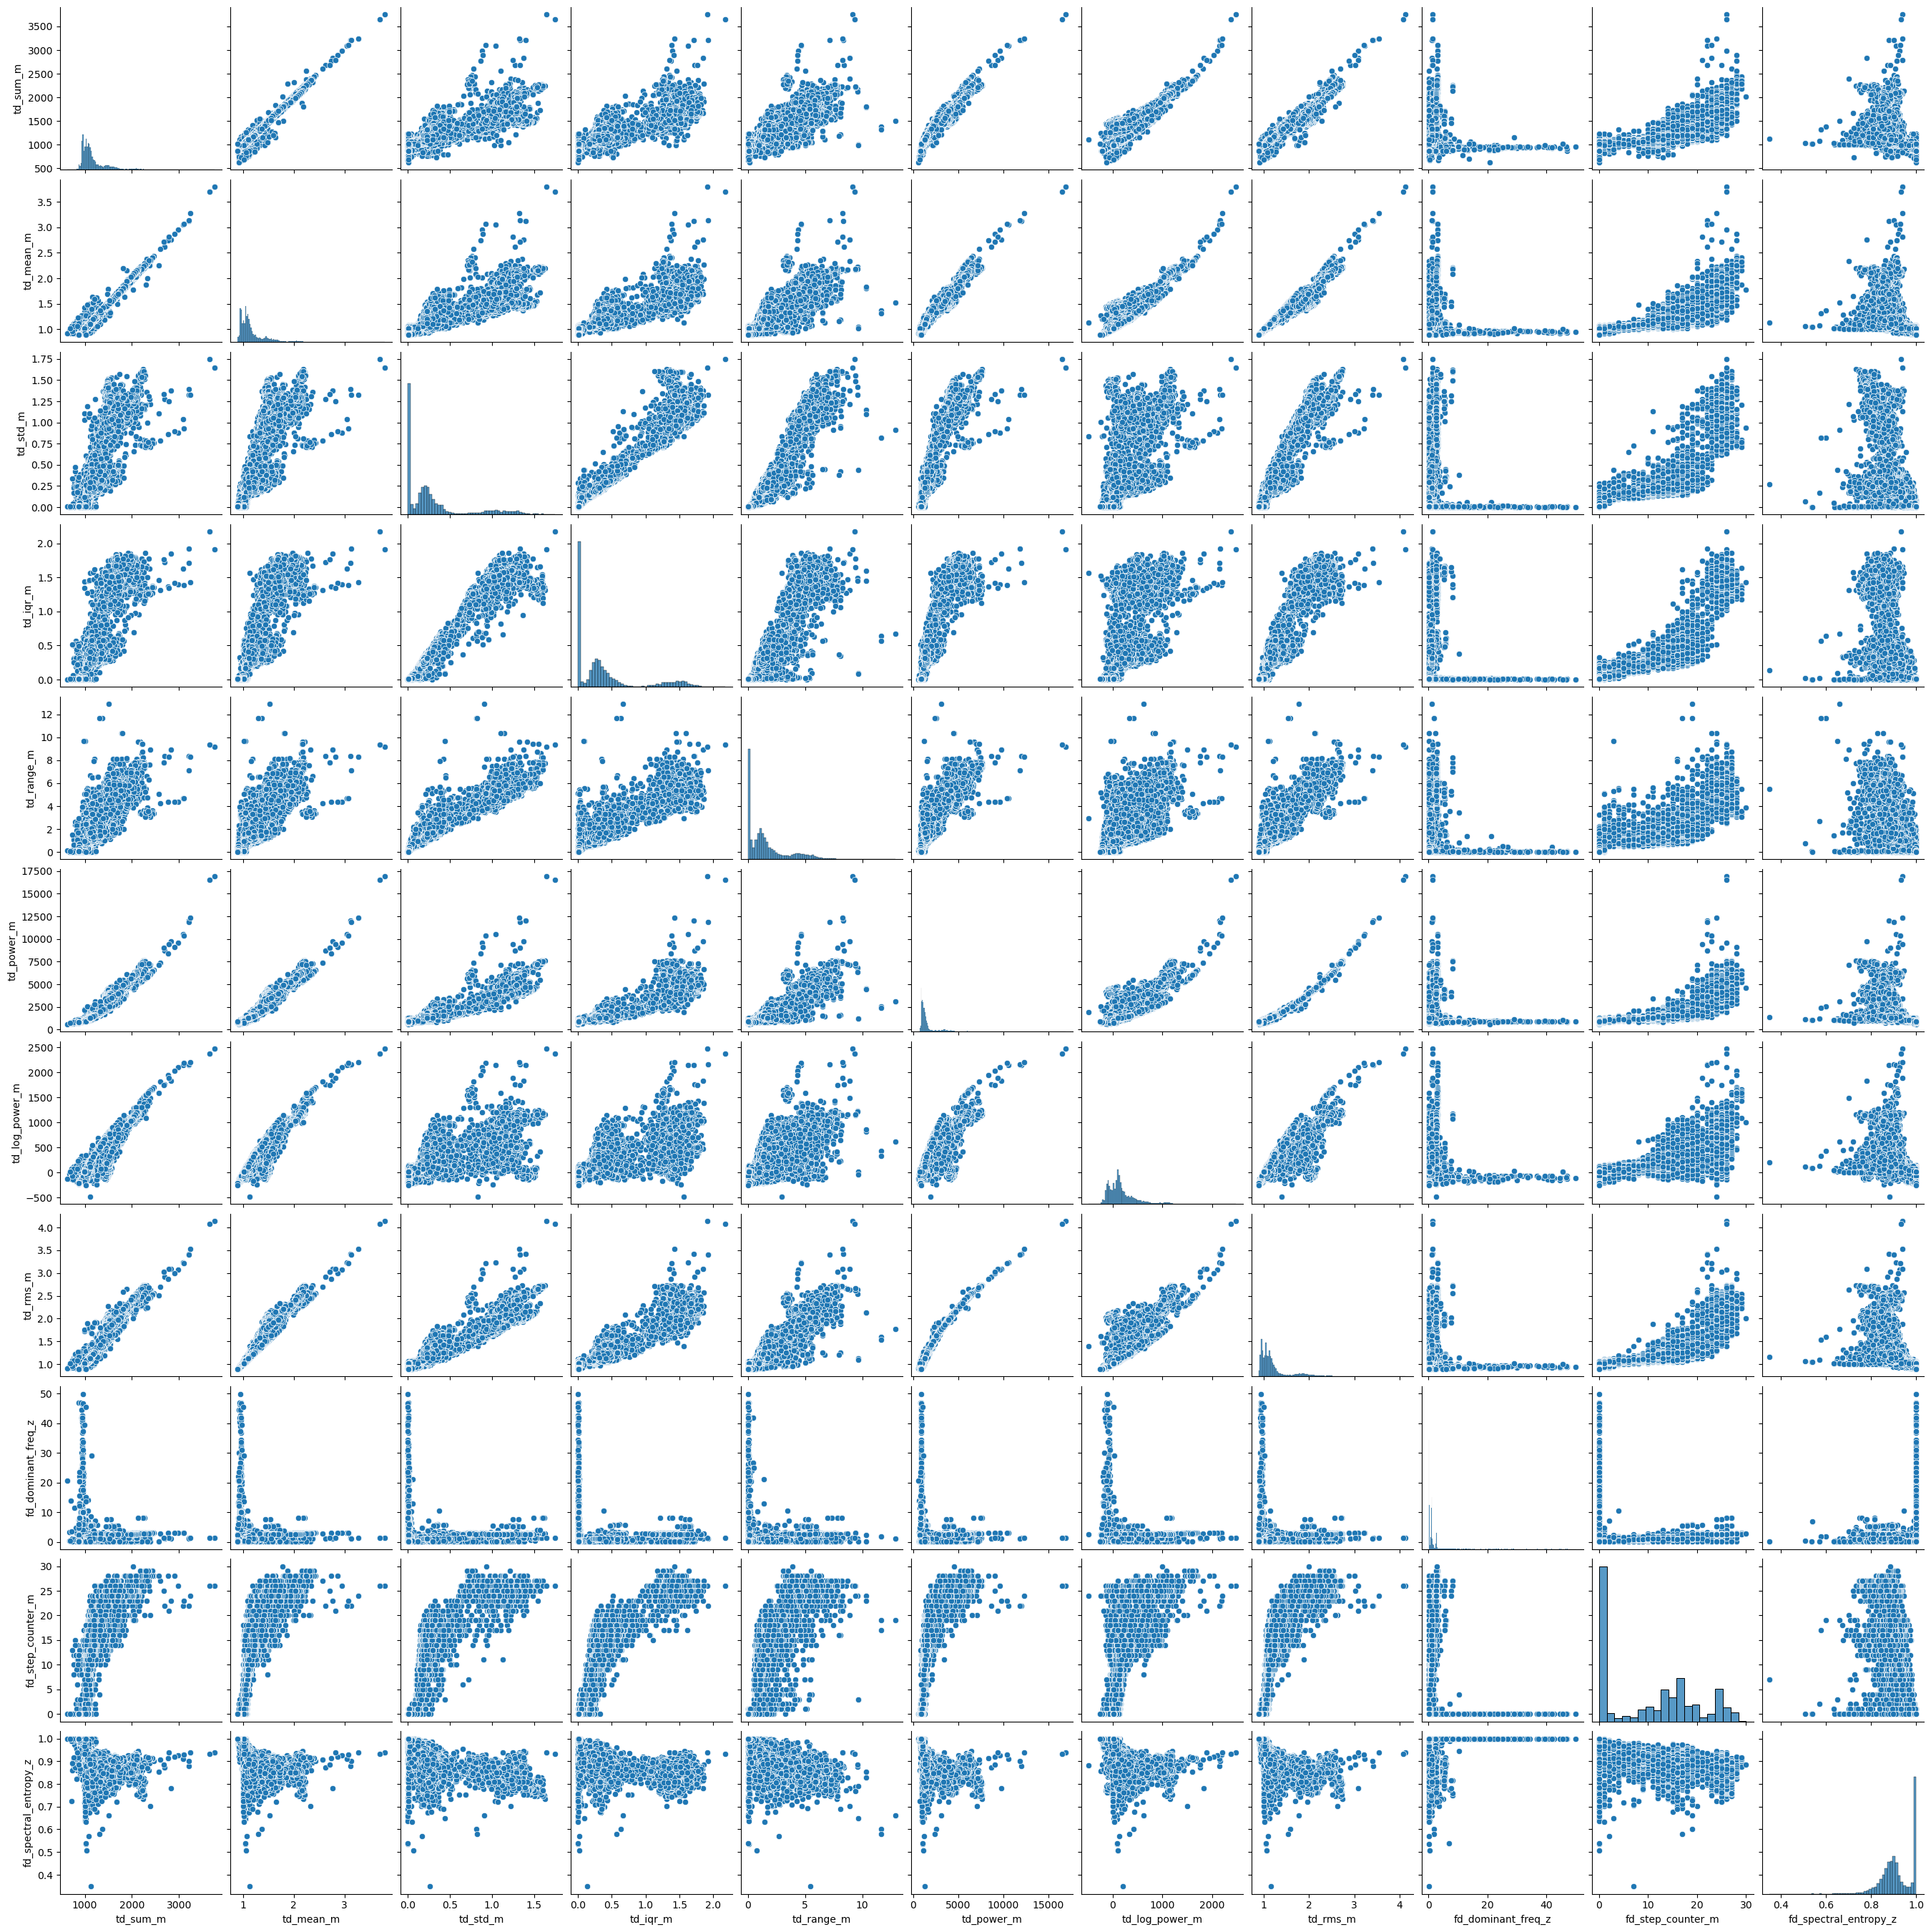

In [14]:
sns.pairplot(time_freq_domain_df[['td_sum_m','td_mean_m','td_std_m','td_iqr_m','td_range_m','td_power_m',
                                  'td_log_power_m','td_rms_m','fd_dominant_freq_z','fd_step_counter_m','fd_spectral_entropy_z']])


In [24]:
def build_label_color_map(class_labels, color_map=plt.cm.tab10):
    label_color_map = {}
    for i,label in enumerate(class_labels):
        label_color_map[label] = color_map(i)
    return label_color_map

def build_colormap(labels_arr, label_color_map):
    color_arr = []
    for label in labels_arr:
        color_arr.append(label_color_map[label])
    return color_arr


label_color_map = build_label_color_map(class_labels = time_freq_domain_df['class'].unique().tolist())
label_color_map



{'stairs': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 'walking': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 'sedentary': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313,
  1.0),
 'running': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)}

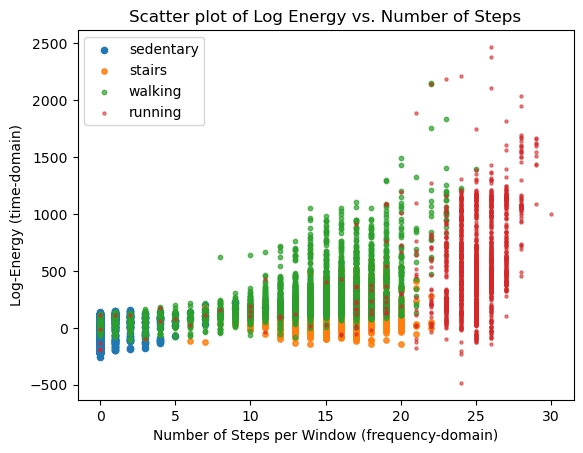

In [180]:
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
cat_scat_df = time_freq_domain_df.sort_values(['class'],key= lambda x: x.map(class_custom_order))
classes = cat_scat_df['class'].unique()

fig, ax = plt.subplots()

for i,c in enumerate(classes):
    ax.scatter(cat_scat_df[cat_scat_df['class']==c]['fd_step_counter_m'], 
                cat_scat_df[cat_scat_df['class']==c]['td_log_power_m'],
                alpha=1-i*0.15, label=c, s=20-i*5)
    
ax.set_title('Scatter plot of Log Energy vs. Number of Steps')
ax.set_xlabel('Number of Steps per Window (frequency-domain)')
ax.set_ylabel('Log-Energy (time-domain)')
ax.legend()
plt.show()

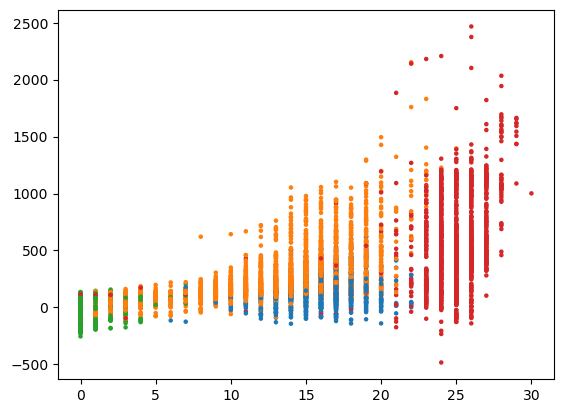

In [43]:
plt.scatter(time_freq_domain_df['fd_step_counter_m'].values,
            time_freq_domain_df['td_log_power_m'].values, s=5,
            c = time_freq_domain_df['class'].map(label_color_map))
# plt.ylim(-300,1800)

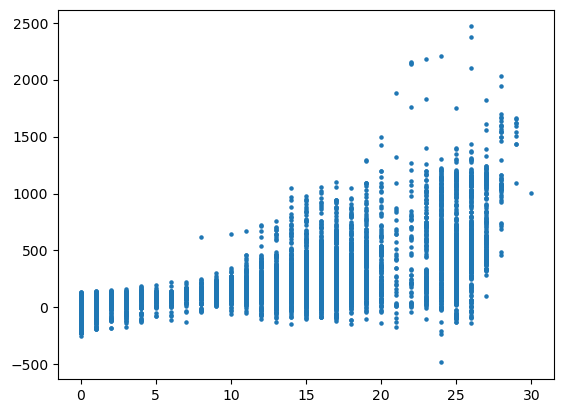

In [37]:
plt.scatter(time_freq_domain_df['fd_step_counter_m'].values,
            time_freq_domain_df['td_log_power_m'].values, s=5)